## Topic Modeling: Latent Dirichlet Allocation with sklearn

### Imports

In [1]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [20]:
# change to your data path if necessary
DATA_DIR = Path('../data')
data_path = DATA_DIR / 'bbc'

In [21]:
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

## Load BBC data

Using the BBC data as before, we use [sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to train an LDA model with five topics.

In [6]:
files = data_path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [10]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [11]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [12]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [13]:
pd.Series(test_docs.topic).value_counts()

Sport            12
Business         11
Tech              9
Politics          9
Entertainment     9
Name: topic, dtype: int64

### Vectorize train & test sets

In [14]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 204945 stored elements in Compressed Sparse Row format>

In [15]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 4759 stored elements in Compressed Sparse Row format>

### LDA with sklearn

In [16]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [17]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Persist model

The model tracks the in-sample perplexity during training and stops iterating once this measure stops improving. We can persist and load the result as usual with sklearn objects:

In [22]:
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')

['results/bbc/lda_10_iter.pkl']

In [23]:
lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Explore topics & word distributions

In [24]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 2899)


array([[13.6484    ,  8.92765995,  1.31418808, ...,  1.99495236,
         0.20661246,  0.73422033],
       [ 1.12298041,  0.57822241,  0.89849244, ...,  0.90932536,
         0.20011641,  0.21499239],
       [ 3.5594674 ,  0.62943508,  0.64723764, ...,  0.34056913,
         0.20001791,  0.30883726],
       [ 0.20017937,  0.20022822,  0.20016096, ...,  0.20015571,
        11.59332613,  0.20018161],
       [ 4.56503009,  0.94708874,  2.04736569, ...,  0.86563724,
         0.20001157,  5.03625788]])

In [25]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00
100m,0.00,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,0.00
12,0.00,0.00,0.00,0.00,0.00


In [26]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

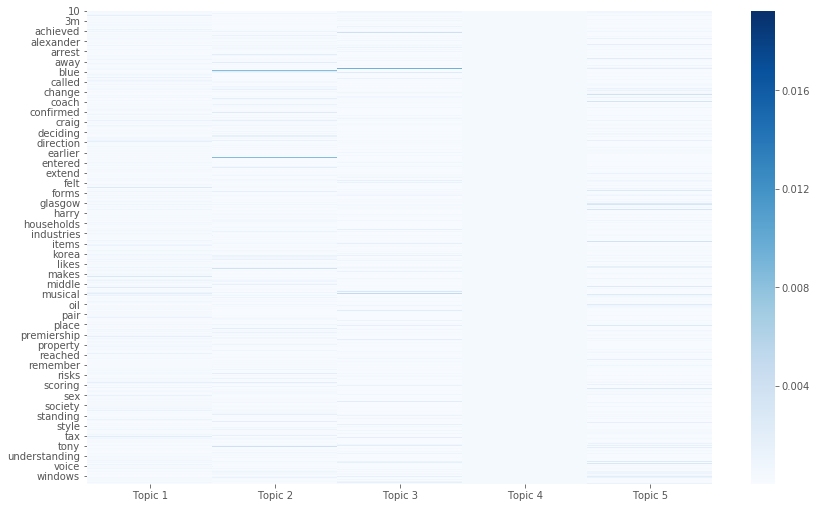

In [27]:
sns.heatmap(topics, cmap='Blues');

In [28]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,company,labour,film,yukos,game
1,market,party,best,russian,england
2,firm,election,awards,sullivan,win
3,sales,blair,award,auction,club
4,mobile,brown,band,mikhail,match
5,growth,minister,star,russia,cup
6,2004,howard,album,ambitions,team
7,technology,prime,music,bankruptcy,play
8,economy,chancellor,actor,court,players
9,million,tory,festival,judge,injury


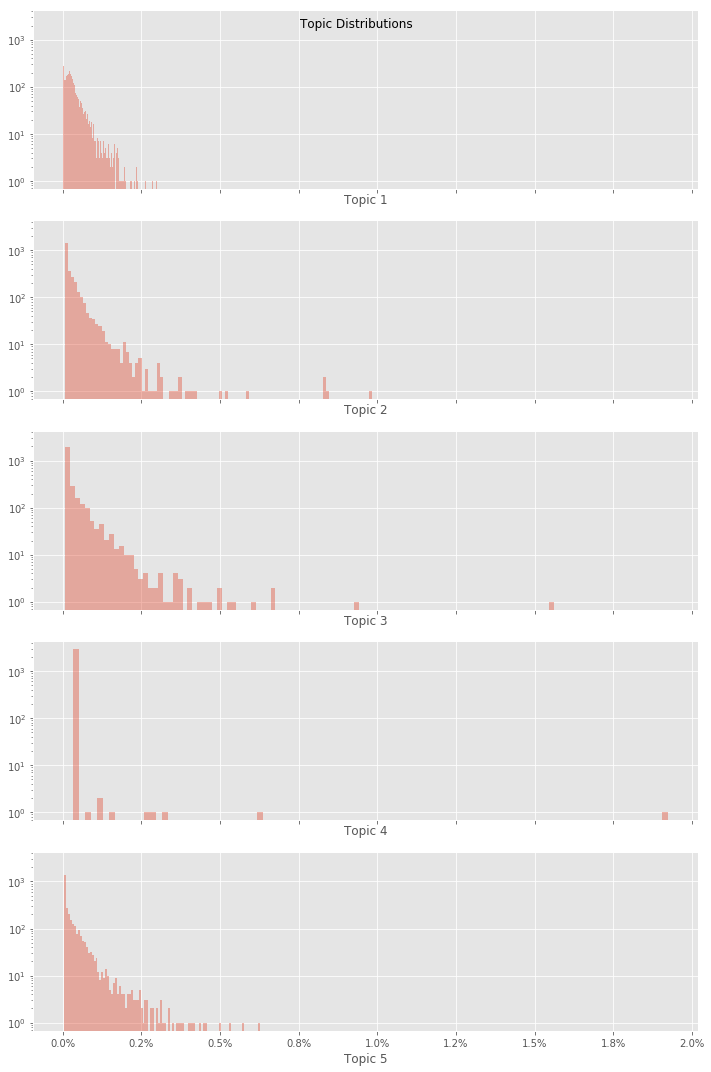

In [29]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

### Evaluate Fit on Train Set

In [30]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2175, 5)

In [31]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Entertainment,0.72,0.20,0.03,0.03,0.03
Tech,0.92,0.02,0.02,0.02,0.02
Entertainment,0.15,0.03,0.77,0.03,0.03
Business,0.91,0.02,0.02,0.02,0.02
Sport,0.03,0.91,0.02,0.02,0.02


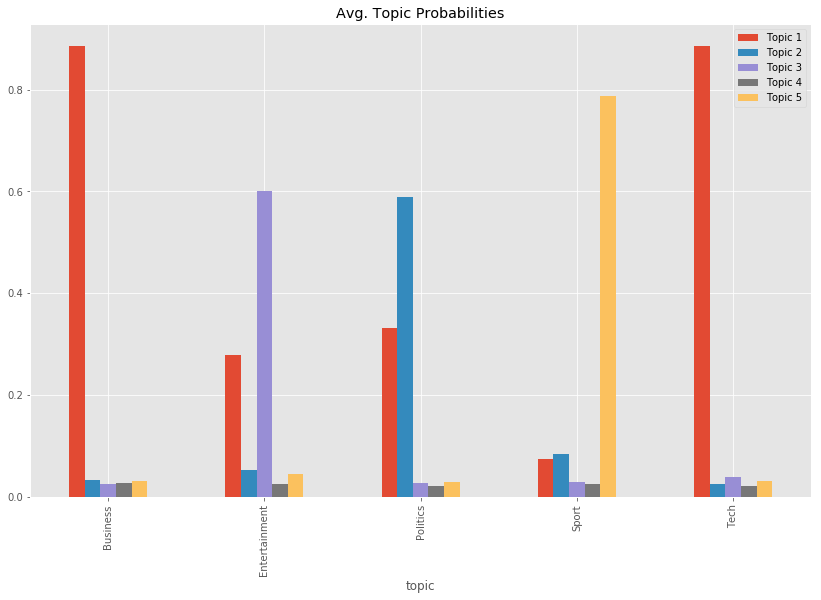

In [32]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

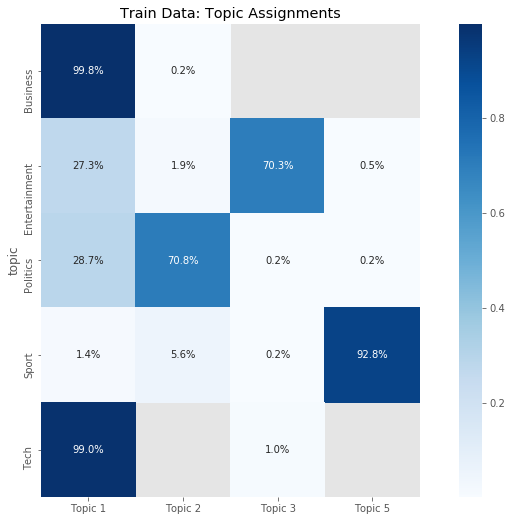

In [33]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

### Evaluate Fit on Test Set 

In [34]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Entertainment,0.03,0.03,0.87,0.03,0.03
Tech,0.89,0.03,0.03,0.03,0.03
Tech,0.70,0.02,0.14,0.02,0.12
Business,0.91,0.02,0.02,0.02,0.03
Sport,0.03,0.03,0.02,0.02,0.90


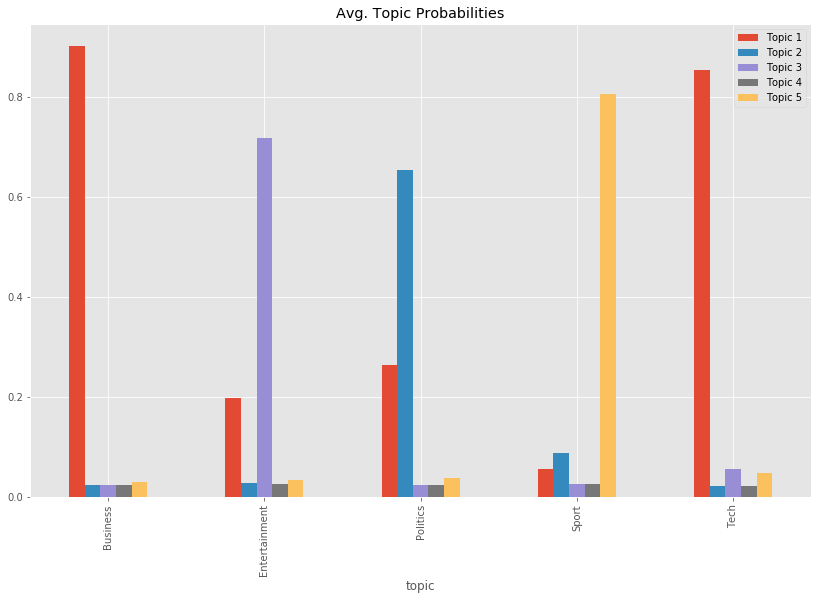

In [35]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

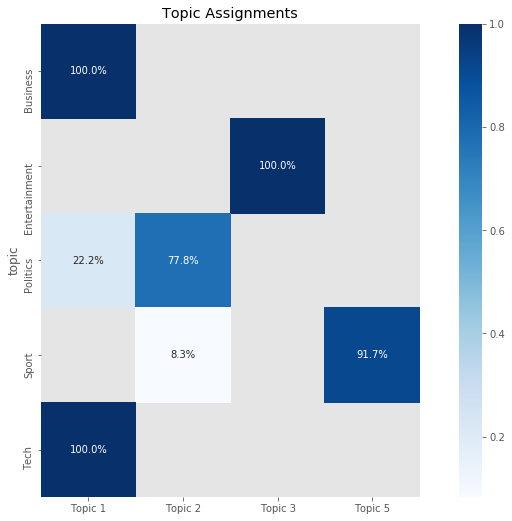

In [36]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

### Retrain until perplexity no longer decreases

In [37]:
lda_opt = LatentDirichletAllocation(n_components=5, 
                                    n_jobs=-1, 
                                    max_iter=500,
                                    learning_method='batch', 
                                    evaluate_every=5,
                                    verbose=1, 
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 5307.4876
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 5138.1714
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 5053.3613
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 4979.2082
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 4942.3991
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [38]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')

['results/bbc/lda_opt.pkl']

In [39]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

In [40]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [41]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

### Compare Train & Test Topic Assignments 

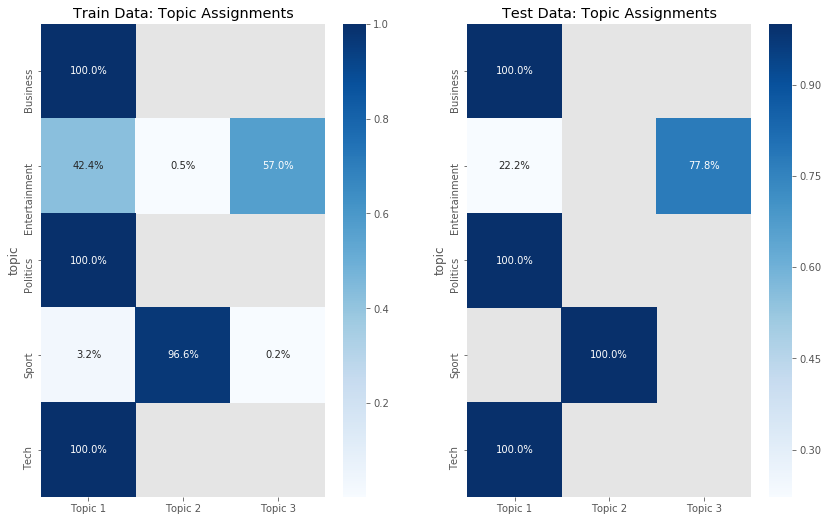

In [42]:
fig, axes = plt.subplots(ncols=2)
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

### Explore misclassified articles 

In [43]:
test_assignments = test_opt_eval.groupby(level='topic').idxmax(axis=1)
test_assignments = test_assignments.reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head()

,topic,predicted,heading,article
0,Business,Topic 1,Brits return Keane to number one,Brits success has helped return Keane's award...
1,Business,Topic 1,Anti-spam screensaver scrapped,A contentious campaign to bump up the bandwid...
2,Business,Topic 1,The Force is strong in Battlefront,The warm reception that has greeted Star Wars...
3,Business,Topic 1,"Rover deal 'may cost 2,000 jobs'","Some 2,000 jobs at MG Rover's Midlands plant ..."
4,Business,Topic 1,Sculthorpe wants Lions captaincy,Paul Sculthorpe has admitted he would love to...


In [44]:
misclassified = test_assignments[(test_assignments.topic == 'business') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

Series([], Name: heading, dtype: object)

In [45]:
misclassified.article.tolist()

[]

### PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

Topic visualization facilitates the evaluation of topic quality using human judgment. pyLDAvis is a python port of LDAvis, developed in R and D3.js. We will introduce the key concepts; each LDA implementation notebook contains examples.

pyLDAvis displays the global relationships among topics while also facilitating their semantic evaluation by inspecting the terms most closely associated with each individual topic and, inversely, the topics associated with each term. It also addresses the challenge that terms that are frequent in a corpus tend to dominate the multinomial distribution over words that define a topic. LDAVis introduces the relevance r of term w to topic t to produce a flexible ranking of key terms using a weight parameter 0<=ƛ<=1. 

With $\phi_{wt}$  as the model’s probability estimate of observing the term w for topic t, and   as the marginal probability of w in the corpus:
$$r(w, k | \lambda) = \lambda \log(\phi_{kw}) + (1 − \lambda) \log \frac{\phi_{kw}}{p_w}$$

The first term measures the degree of association of term t with topic w, and the second term measures the lift or saliency, i.e., how much more likely the term is for the topic than in the corpus. 

The tool allows the user to interactively change ƛ to adjust the relevance, which updates the ranking of terms. User studies have found that ƛ=0.6 produces the most plausible results. 

#### Refit using all data

In [46]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [47]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1022.6552
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1007.1868
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1695
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [48]:
joblib.dump(lda_all, model_path /'lda_all.pkl')

['results/bbc/lda_all.pkl']

In [49]:
lda_all = joblib.load(model_path / 'lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [50]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2      0.07  0.08       1        1 25.51
3      0.09 -0.10       2        1 21.82
0      0.14  0.01       3        1 20.96
4     -0.14  0.14       4        1 18.70
1     -0.17 -0.13       5        1 13.01, topic_info=     Category     Freq        Term    Total  loglift  logprob
1200  Default 2,987.00          mr 2,987.00    30.00    30.00
724   Default   838.00        film   838.00    29.00    29.00
230   Default   960.00        best   960.00    28.00    28.00
1022  Default   770.00      labour   770.00    27.00    27.00
780   Default   855.00        game   855.00    26.00    26.00
817   Default 1,151.00  government 1,151.00    25.00    25.00
1206  Default   810.00       music   810.00    24.00    24.00
619   Default   630.00    election   630.00    23.00    23.00
1305  Default   624.00       party   624.00    22.00    22.00
1177  Default   521.00      mobile   521.00    21.00    21.00
1788  Default   553.00  technology   553.00    20.00    20.00
240   Default   551.00       blair   551.00    19.00    19.00
631   Default   593.00     england   593.00    18.00    18.00
1319  Default 2,030.00      people 2,030.00    17.00    17.00
1129  Default   683.00      market   683.00    16.00    16.00
1884  Default   406.00       users   406.00    15.00    15.00
551   Default   404.00     digital   404.00    14.00    14.00
195   Default   291.00      awards   291.00    13.00    13.00
194   Default   280.00       award   280.00    12.00    12.00
1658  Default   373.00    software   373.00    11.00    11.00
205   Default   360.00        bank   360.00    10.00    10.00
832   Default   443.00      growth   443.00     9.00     9.00
1170  Default   552.00    minister   552.00     8.00     8.00
1329  Default   373.00       phone   373.00     7.00     7.00
1968  Default   589.00         won   589.00     6.00     6.00
403   Default   678.00     company   678.00     5.00     5.00
1346  Default   513.00     players   513.00     4.00     4.00
1957  Default   580.00         win   580.00     3.00     3.00
380   Default   364.00        club   364.00     2.00     2.00
608   Default   421.00     economy   421.00     1.00     1.00
...       ...      ...         ...      ...      ...      ...
575    Topic5    56.72      doping    57.52     2.03    -6.48
387    Topic5   130.06      comedy   131.91     2.03    -5.65
724    Topic5   818.47        film   838.10     2.02    -3.81
1661   Topic5   171.90        song   177.54     2.01    -5.38
204    Topic5   211.33        band   223.18     1.99    -5.17
1395   Topic5   148.73       prize   158.69     1.97    -5.52
325    Topic5   102.17    ceremony   107.12     1.99    -5.90
1705   Topic5   127.00       stars   137.86     1.96    -5.68
1703   Topic5   249.12        star   292.57     1.88    -5.00
230    Topic5   698.84        best   960.17     1.72    -3.97
1456   Topic5   101.37         ray   108.11     1.98    -5.90
725    Topic5   211.01       films   254.01     1.85    -5.17
316    Topic5    95.88    category   102.16     1.98    -5.96
1206   Topic5   404.05       music   810.44     1.34    -4.52
1194   Topic5   127.67       movie   158.77     1.82    -5.67
1968   Topic5   290.56         won   589.23     1.33    -4.85
556    Topic5   230.87    director   426.78     1.43    -5.08
266    Topic5   224.16     british   533.06     1.17    -5.11
920    Topic5   182.56   including   404.97     1.24    -5.31
1238   Topic5   228.73      number   748.61     0.85    -5.09
1992   Topic5   232.24       years   991.66     0.59    -5.07
1224   Topic5   285.88         new 1,896.89     0.15    -4.87
1863   Topic5   176.87          tv   481.87     1.04    -5.35
1866   Topic5   210.95          uk 1,047.95     0.44    -5.17
216    Topic5   162.82         bbc   747.90     0.52    -5.43
1081   Topic5   145.36      london   454.66     0.90    -5.54
1816   Topic5   158.76        time 1,303.51    -0.07    -5.45
1607   Topic

### Topics as WordClouds

In [51]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

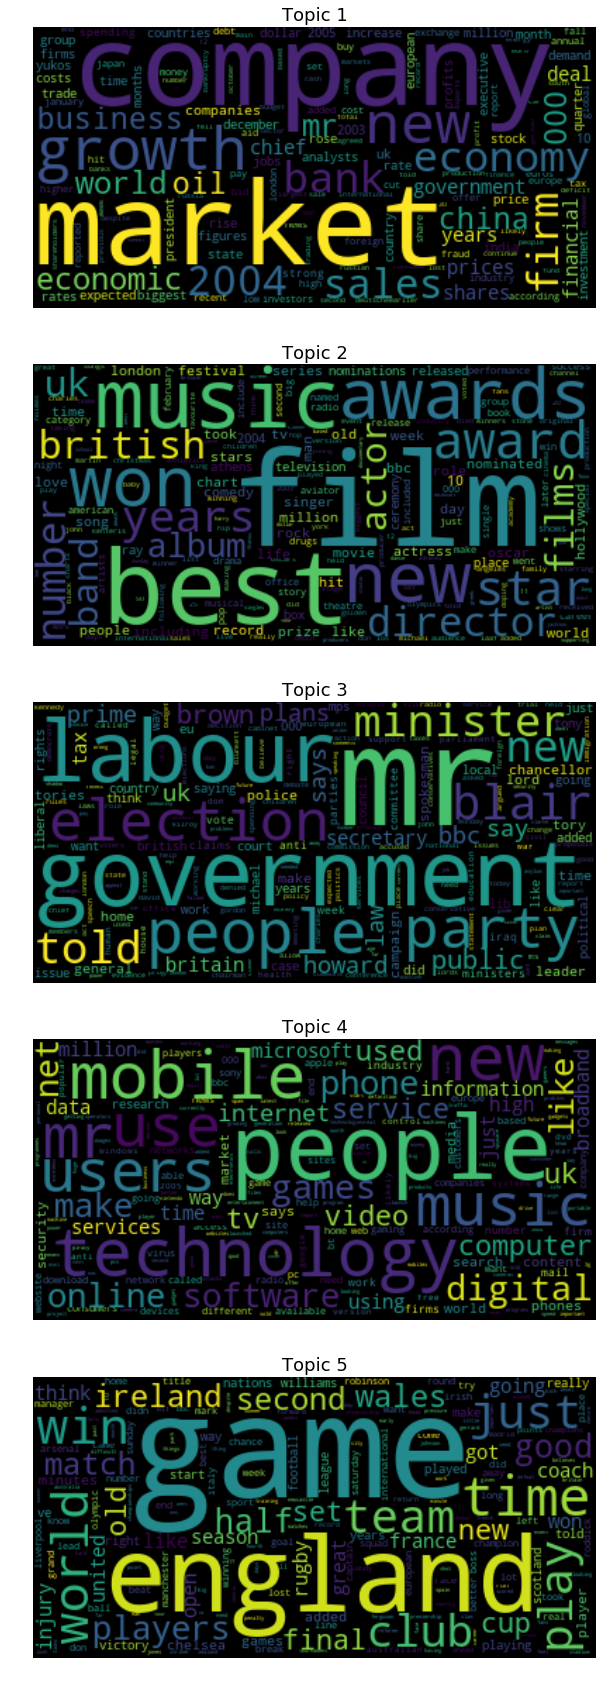

In [52]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [53]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [54]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [55]:
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.1).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
Entertainment,0.14,0.28,0.23,0.23,0.11,Women in the UK film industry earn less than ...,Women in film 'are earning less'


In [57]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Women in film 'are earning less' 

Women in the UK film industry earn less than their male counterparts despite being better qualified, according to a study released on Wednesday. Only 16% of women earn more than Â£50,000, compared with 30% of men. Women make up a third of the workforce. The research was carried out jointly by the UK Film Council and industry training body Skillset. It also found that women in the industry were less likely than men to be married or have dependant children. The study, which claims to be the most in-depth so far conducted, found 60% of women in the film industry hold degrees, compared with 39% of men. Whilst 17% of men in the industry had no qualifications, this was true for only five per cent of women. In the lower salary bracket, 35% of women earn less than Â£20,000 a year, compared to only 18% of men. The research found very few women worked in the camera, sound, electrical and construction departments, but th